###### Build a linear regression model that identifies the key drivers of interest rate for individual loans. Perform exploratory data analysis of the relationship between the features and relationship of the features with the response. Select your features and appropriate transformations and use statsmodels or sklearn to build a linear regression model.

###### You do not have to use all the variables. Focus on building the simplest model that explains interest rate. Justify the features you have or have not included in your model.

### Perform basic EDA

In [71]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_diabetes

In [72]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# read dataset.csv
bank_data = pd.read_csv("../data/bank_interest_model.csv")
# bank_data = bank_data.transpose()
print("\nPreview of bank dataset", bank_data.T.head(5))

# count the rows and columns in a DataFrame
print("\nNumber of rows and column in our DataFrame = ",bank_data.shape)


Preview of bank dataset                                0        1        2        3        4     \
interest_rate                   8.9    12.12    21.98     9.99    11.71   
fico_range                  735-739  715-719  690-694  695-699  695-699   
amount_requested            20000.0  19200.0  35000.0  10000.0  12000.0   
amount_funded_by_investors  20000.0  19200.0  35000.0   9975.0  12000.0   
loan_length                    36.0     36.0     60.0     36.0     36.0   

                               5        6        7        8        9     ...  \
interest_rate                 15.31      7.9    17.14    14.33     6.91  ...   
fico_range                  670-674  720-724  705-709  685-689  715-719  ...   
amount_requested             6000.0  10000.0  33500.0  14675.0   7000.0  ...   
amount_funded_by_investors   6000.0  10000.0  33450.0  14675.0   7000.0  ...   
loan_length                    36.0     36.0     60.0     36.0     36.0  ...   

                               2488     248

In [73]:
# displays the data type and information about the data
# 4/5 Dtypes are float64, 1/5 Dtypes are object
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   float64
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   float64
dtypes: float64(4), object(1)
memory usage: 97.7+ KB


In [74]:
# Checking for duplication
# numbers represent how many unique values there are
bank_data.nunique()

interest_rate                 273
fico_range                     38
amount_requested              380
amount_funded_by_investors    708
loan_length                     2
dtype: int64

In [75]:
# checks for any null values
# zero null values found
bank_data.isnull().sum()

interest_rate                 0
fico_range                    0
amount_requested              0
amount_funded_by_investors    0
loan_length                   0
dtype: int64

#### What columns do we think are valuable when caculating interest rates?
- Fico scores should have a direct positive and negative correlation with interest rates
- Loan length should have a direct correlation with interest rates
- The column "amount_requested" does not represent a significant interest to this EDA 

In [76]:
# Drop amount_requested column
# bank_data = bank_data.drop(columns='amount_requested')
print(bank_data)

      interest_rate fico_range  amount_requested  amount_funded_by_investors  \
0              8.90    735-739           20000.0                    20000.00   
1             12.12    715-719           19200.0                    19200.00   
2             21.98    690-694           35000.0                    35000.00   
3              9.99    695-699           10000.0                     9975.00   
4             11.71    695-699           12000.0                    12000.00   
...             ...        ...               ...                         ...   
2493          16.77    705-709           30000.0                    29950.00   
2494          14.09    740-744           16000.0                    16000.00   
2495          13.99    680-684           10000.0                    10000.00   
2496          12.42    675-679            6000.0                     6000.00   
2497          13.79    670-674            9000.0                     5242.75   

      loan_length  
0            36.0  

In [77]:
# Map Loan Lengths
bank_data['loan_length'] = bank_data['loan_length'].map({36:0, 60:1})

### Feature Engineering
- Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data when creating a predictive model using machine learning or statistical modeling. The main goal of Feature engineering is to create meaningful data from raw data.

In [78]:
# Given fico_range a numerical value based off its mean
bank_data['fico_range'] = bank_data['fico_range'].apply(lambda x: sum(map(int, x.split('-'))) / 2.0)

In [79]:
# visually confirmed fico_range values have been converted into numerical value
bank_data

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length
0,8.90,737.0,20000.0,20000.00,0
1,12.12,717.0,19200.0,19200.00,0
2,21.98,692.0,35000.0,35000.00,1
3,9.99,697.0,10000.0,9975.00,0
4,11.71,697.0,12000.0,12000.00,0
...,...,...,...,...,...
2493,16.77,707.0,30000.0,29950.00,1
2494,14.09,742.0,16000.0,16000.00,1
2495,13.99,682.0,10000.0,10000.00,0
2496,12.42,677.0,6000.0,6000.00,0


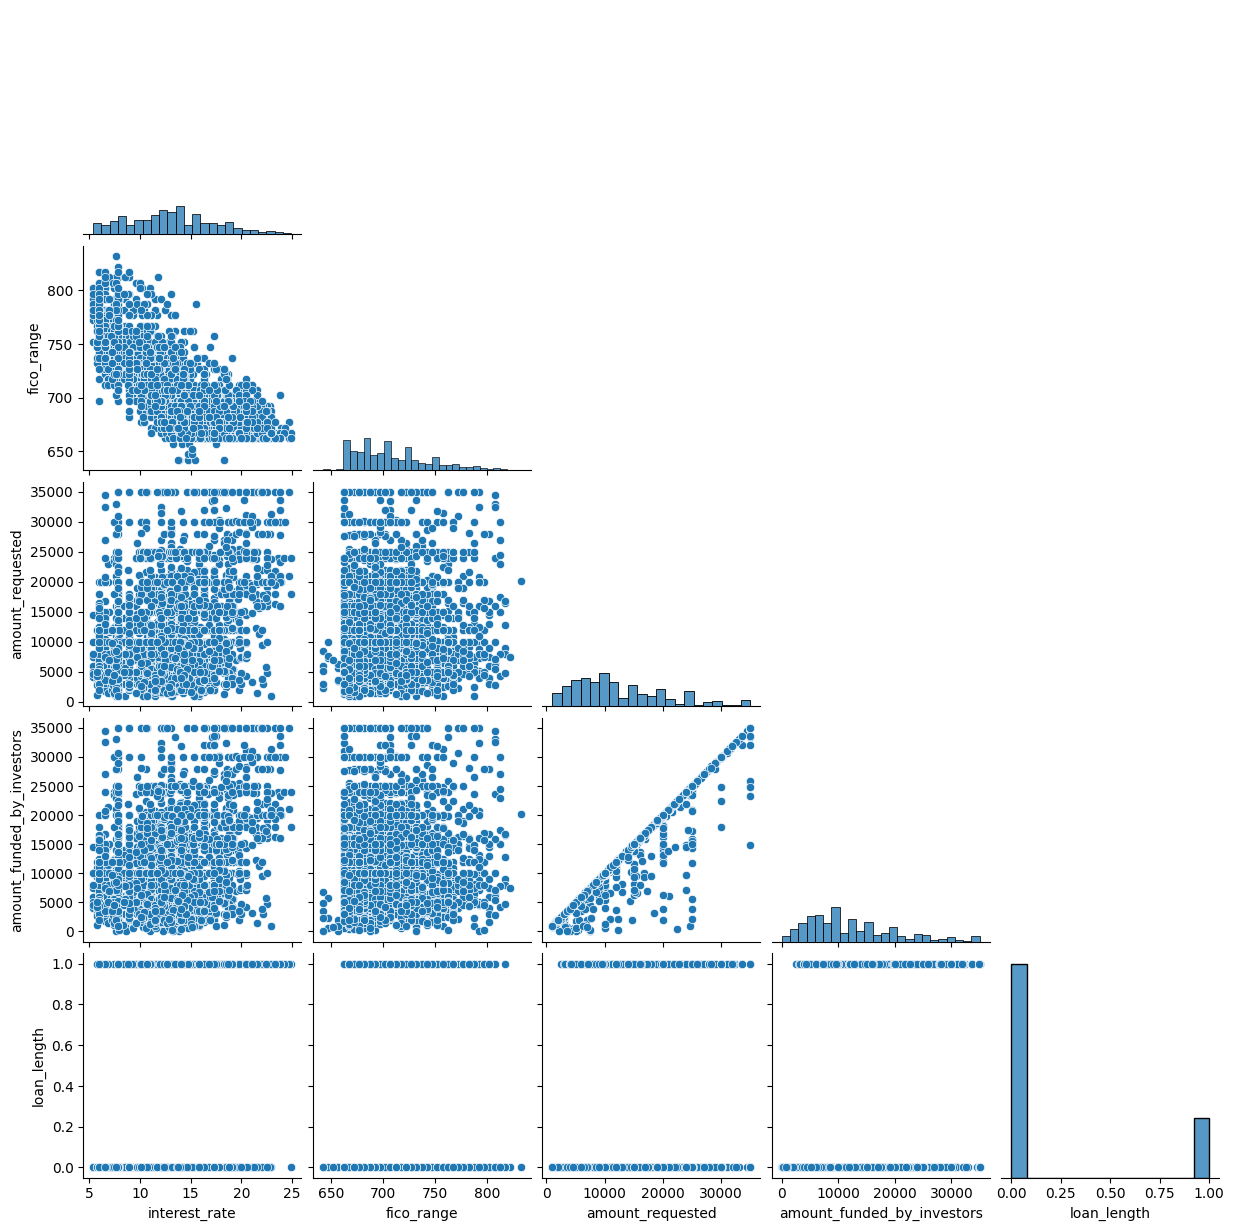

In [80]:
# created a pair plot to identify relationships between variables
sns.pairplot(data=bank_data, corner=True)

##### Make Features

In [81]:
# Creates OLS Regresssion Results
# Allows us to see what values are important to us by looking at the P value
# Observed p values are all zero
X_banking = sm.add_constant(bank_data[['fico_range', 'amount_funded_by_investors', 'loan_length']])
y_banking = bank_data['interest_rate']
model_banking = sm.OLS(y_banking, X_banking)
results_banking = model_banking.fit()
print(results_banking.summary())


                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     2433.
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:50:31   Log-Likelihood:                -5407.3
No. Observations:                2498   AIC:                         1.082e+04
Df Residuals:                    2494   BIC:                         1.085e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Axes: xlabel='predicted', ylabel='residuals'>

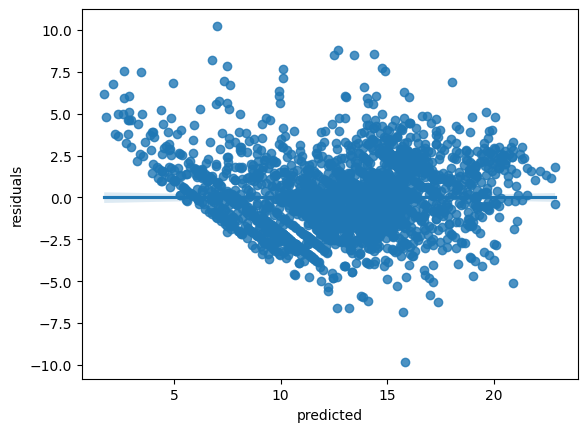

In [82]:
# Added columns predicted and residuals
bank_data['predicted'] = results_banking.predict(X_banking)
bank_data['residuals'] = y_banking - bank_data['predicted']

# Created regression plot
sns.regplot(x=bank_data['predicted'], y=bank_data['residuals'])

C:\Users\beans\AppData\Local\Temp\ipykernel_49744\1222236968.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_data_sample['predicted'] = results_banking.predict(X_banking)
C:\Users\beans\AppData\Local\Temp\ipykernel_49744\1222236968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_data_sample['residuals'] = y_banking - bank_data_sample['predicted']


Text(0.5, 1.0, 'Heteroedonestic Graph')

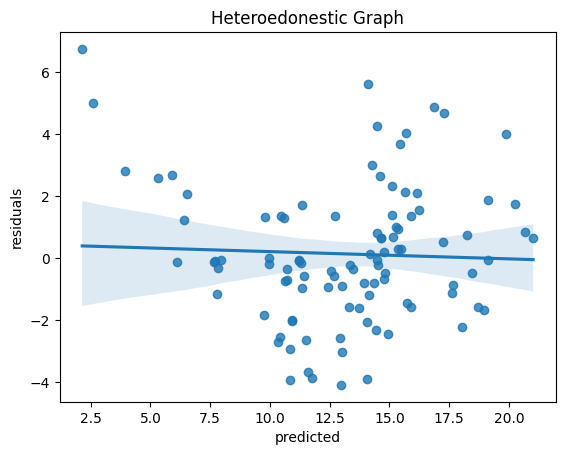

In [83]:
# Took a sample of 100 datapoints from bank_data
# Based off these samples we can check if the data is heteroscedastic
# We can see that the predicted values are not normally distributed and the residuals
bank_data_sample = bank_data.head(100)
X_banking = sm.add_constant(bank_data_sample[['fico_range', 'amount_funded_by_investors', 'loan_length']])
y_banking = bank_data_sample['interest_rate']
bank_data_sample['predicted'] = results_banking.predict(X_banking)
bank_data_sample['residuals'] = y_banking - bank_data_sample['predicted']

# Created regression plot
sns.regplot(x=bank_data_sample['predicted'], y=bank_data_sample['residuals'])
plt.title("Heteroscedastic Graph")

Text(0.5, 1.0, 'Quartile Interest Rate Assessments')

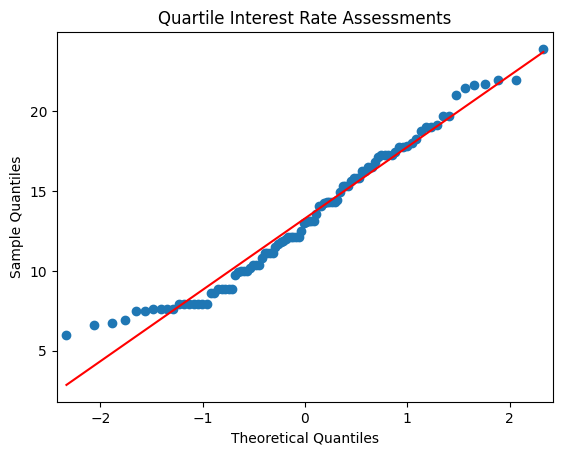

In [98]:
# Sort the P values
# Generates a linear regression graph
# Checking to see if the residuals are normally distributed
# Looking at this graph, we can see that  the majority of our data has a good fit according to our quartile analysis.
# Looking at the first quartile, we can see that our data is being underfitted.
bank_sample_sorted = bank_data_sample['interest_rate'].sort_values()
sm.qqplot(bank_sample_sorted, line='r');
plt.title("Quartile Interest Rate Assessments")

In [85]:
# What the eff is a Decision Tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_banking, y_banking)
y_tree_pred = tree.predict(X_banking)

In [86]:
# # arange for creating a range of values 
# # from min value of X to max value of X 
# # with a difference of 0.01 between two
# # consecutive values
# X_grid = np.arange(min(X_banking), max(X_banking), 0.01)
  
# # reshape for reshaping the data into 
# # a len(X_grid)*1 array, i.e. to make
# # a column out of the X_grid values
# X_grid = X_grid.reshape((len(X_grid), 1)) 
  
# # scatter plot for original data
# plt.scatter(X_banking, y_banking, color = 'red')
  
# # plot predicted data
# plt.plot(X_grid, tree.predict(X_grid), color = 'blue') 
  
# # specify title
# plt.title('Balance to Limit (Decision Tree Regression)') 
  
# # specify X axis label
# plt.xlabel('Limit')
  
# # specify Y axis label
# plt.ylabel('Balance')
  
# # show the plot
# plt.show()

In [87]:
X1 = bank_data['fico_range'].values.reshape(-1, 1)  # Reshaped to a 2D array
y1 = bank_data['interest_rate']

# Check the name variables. I added 1.

# Split!
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

# Build a model!
fico_model = LinearRegression()

# Train!
fico_model.fit(X_train1, y_train1)

# Predict!
y_pred1 = fico_model.predict(X_test1)

# Evaluate!
mse1 = mean_squared_error(y_test1, y_pred1)
r_squared1 = r2_score(y_test1, y_pred1)

print(f"Mean Squared Error is {mse1}")
print(f"R-squared is {r_squared1}")

# Get the slope and intercept too. 
slope1 = fico_model.coef_[0]
intercept1 = fico_model.intercept_

print(f"Slope is {slope1}")
print(f"Intercept is {intercept1}")

Mean Squared Error is 9.052516461405434
R-squared is 0.4728266846396292
Slope is -0.08478758361430305
Intercept is 73.0358946998955


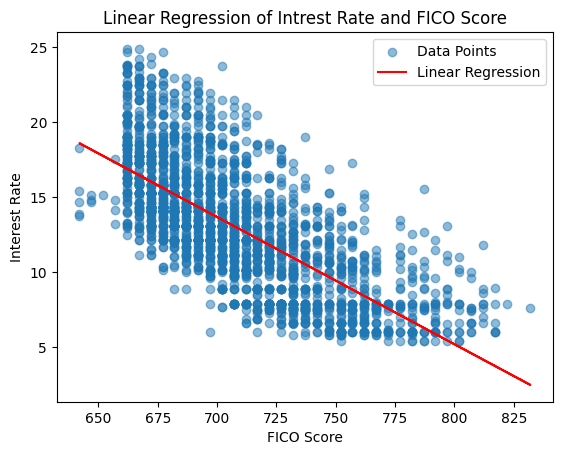

In [88]:
import matplotlib.pyplot as plt

# Scatter plot of actual data points
plt.scatter(X1, y1, label='Data Points', alpha=0.5)

# Linear regression line
plt.plot(X_test1, y_pred1, color='red', label='Linear Regression')
plt.xlabel('FICO Score')
plt.ylabel('Interest Rate')
plt.title('Linear Regression of Interest Rate and FICO Score')
plt.legend()
plt.show()

### Creating Our Linear Regression Model

In [89]:
# This generates test values from our training data 

# Creating a training and testing set
# test_size=0.2 is 20% of the data as the sample set
X_train, X_test, y_train, y_test = train_test_split(X_banking, y_banking, test_size=0.2, random_state=0)

# Created variable for Ridge Regression
ridge_model = Ridge(alpha=.5)

# This fits the ridge regression to the training data
ridge_model.fit(X_train, y_train)

# This predicts the testing data from the ridge regression model
predict = ridge_model.predict(X_test)

In [90]:
# Prints test values from X_banking and y_banking
print(predict)

[14.89230561  1.98047534 19.84218085 11.15313192 14.5970913  14.6808896
 13.25075909 16.24161891 17.84055032  7.83798808 20.81060693 15.51410826
 16.03020289 12.18224878 18.28861153 19.1267772  19.14570582 18.41819517
 18.29696935 14.67142529]


In [91]:
# This prints y_test values from y_banking data. 
# Sample size is 20% from the population
print(y_test)

26    14.42
86     8.90
2     21.98
55    11.14
75    13.12
93    14.35
16    12.12
73    17.27
54    17.80
95     6.62
53    21.49
92    15.81
78    17.77
13     8.90
7     17.14
30    21.00
22    17.99
24    16.82
33    15.80
8     14.33
Name: interest_rate, dtype: float64


In [92]:
# Find the mean square errors (Smaller is better)
# Square errors found represent the caculation of true values and predicted values from the regression model
mean_squared_error(y_test, predict)

4.410235391621696

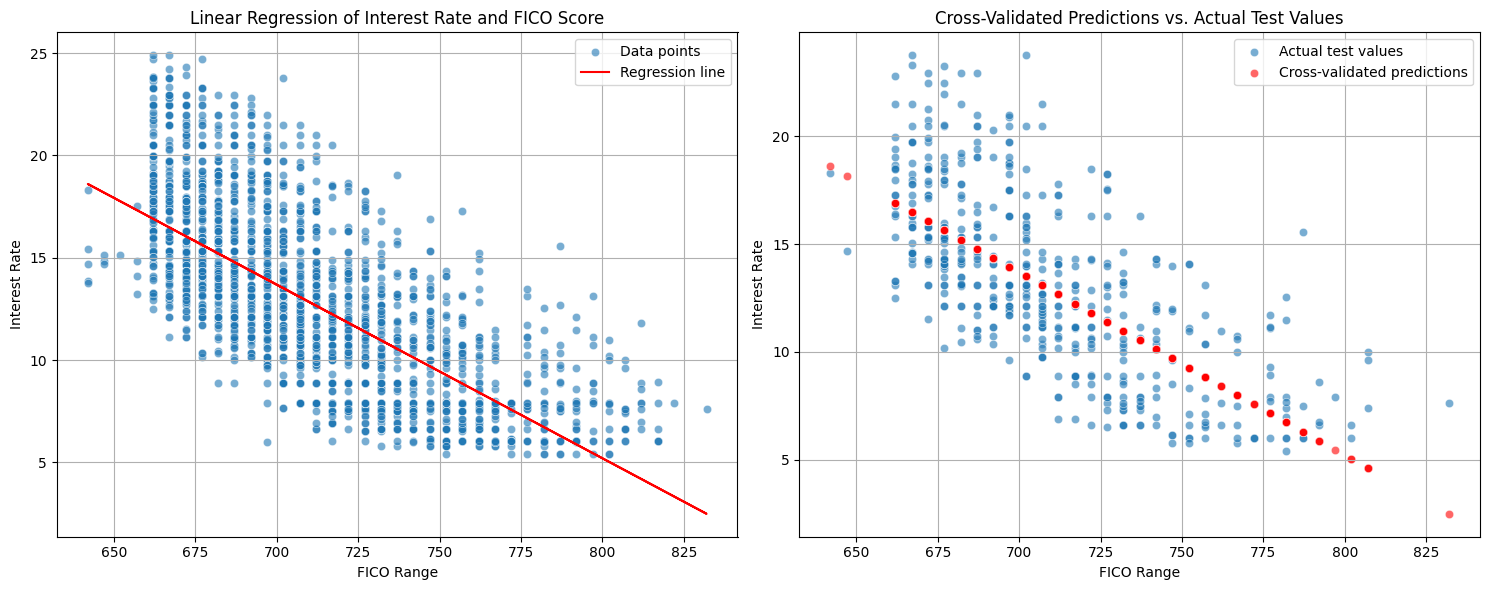

In [99]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

# Build a model
fico_model = LinearRegression()

# Train the model
fico_model.fit(X_train1, y_train1)

# Predict on the test set
y_pred1 = fico_model.predict(X_test1)

# Evaluate the model
mse1 = mean_squared_error(y_test1, y_pred1)
r_squared1 = r2_score(y_test1, y_pred1)

# Perform cross-validation!
cv_scores = cross_val_score(fico_model, X1, y1, cv=5, scoring='neg_mean_squared_error')
mse_cv = -np.mean(cv_scores)
r_squared_cv = np.mean(cross_val_score(fico_model, X1, y1, cv=5, scoring='r2'))

# Get the slope and intercept too!
slope1 = fico_model.coef_[0]
intercept1 = fico_model.intercept_

# I'm going to make two plots side by side
plt.figure(figsize=(15, 6))

# First subplot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X1.flatten(), y=y1, alpha=0.6, label='Data points')
plt.plot(X1.flatten(), fico_model.predict(X1).flatten(), color='red', label='Regression line')
plt.xlabel('FICO Range')
plt.ylabel('Interest Rate')
plt.title('Linear Regression of Interest Rate and FICO Score')
plt.legend()
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test1.flatten(), y=y_test1, alpha=0.6, label='Actual test values')
sns.scatterplot(x=X_test1.flatten(), y=y_pred1, color='red', alpha=0.6, label='Cross-validated predictions')
plt.xlabel('FICO Range')
plt.ylabel('Interest Rate')
plt.title('Cross-Validated Predictions vs. Actual Test Values')
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

In [94]:
# Find RMSE value
def rmse(true, predicted):
    MSE = np.square(np.subtract(true,predicted)).mean() 
    # print(MSE ==mean_squared_error(true,predicted))
    return np.sqrt(MSE)

# Fit your model using the training set
reg = LinearRegression()
reg.fit(X_train, y_train)

# Call predict to get the predicted values for training and test set
train_predicted = reg.predict(X_train)
test_predicted = reg.predict(X_test)
# Calculate RMSE for training and test set
rmse_train = rmse(y_train,train_predicted)
rmse_test = rmse(y_test,test_predicted)

print( 'RMSE for training set ', rmse_train )
print( 'RMSE for test set ', rmse_test)
print(X_train.shape)

RMSE for training set  2.183810674244167
RMSE for test set  2.1118245144145944
(80, 4)


Cross Validation

In [95]:
# Cross Validation
def cross_val(X_train, y_train, k):
    scores = []
    split_k = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in split_k.split(X_train):
        # from chad discussion
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        model = LinearRegression()
        model.fit(X_train_fold, y_train_fold)
        pred = model.predict(X_test_fold)

        rmse_fold = rmse(y_test_fold, pred)
        scores.append(rmse_fold)

        avg_scores = np.mean(scores)
    return avg_scores

print("cross_val: ",cross_val(X_train.values,y_train.values,k=5))
reg = LinearRegression()
reg.fit(X_train, y_train)
print("cross_val_score: ",np.abs(np.mean(cross_val_score(reg,X_train, y_train, scoring="neg_root_mean_squared_error"))))

cross_val:  2.248799583292329
cross_val_score:  2.4002063815809445


Cross Val List

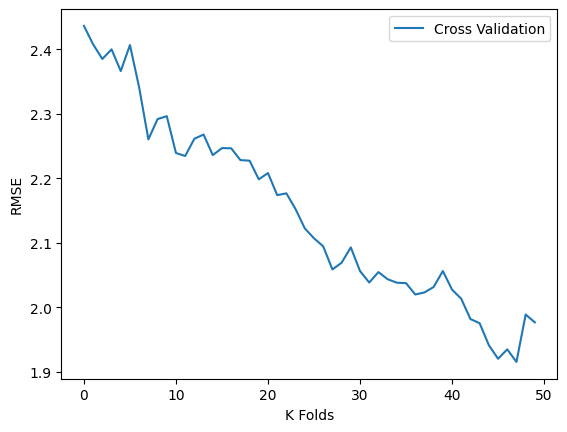

In [96]:
# Use Pending
def cross_val_size(reg,X, y,size):
  scores = []
  for i in range(2, size + 2):
    scores.append(np.abs(np.mean(cross_val_score(reg,X, y, cv=i, scoring="neg_root_mean_squared_error"))))
  return scores
plt.plot(cross_val_size(reg, X_train, y_train, 50), label = 'Cross Validation')
plt.ylabel('RMSE')
plt.xlabel('K Folds')
plt.legend()

Cross-validated predictions:
[10.63793951 12.31110507 14.40256203 ... 15.23032655 15.65729465
 16.08426276]


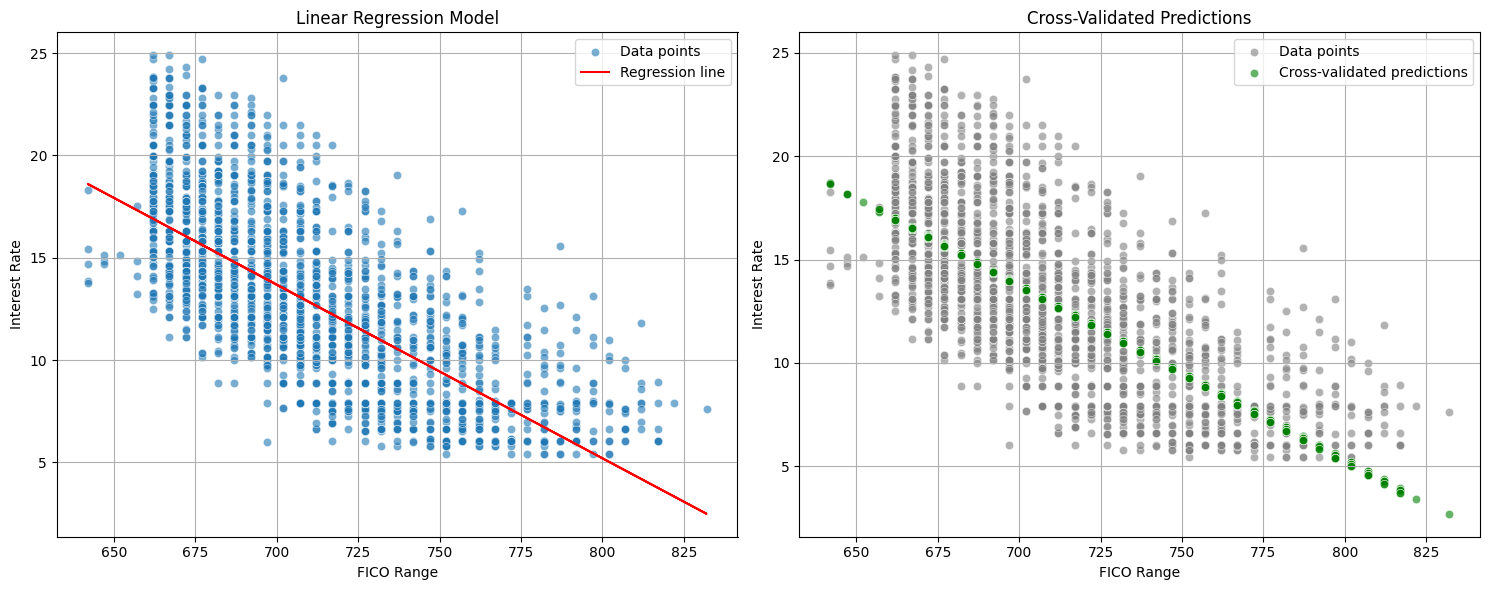

In [97]:
from sklearn.model_selection import cross_val_score, cross_val_predict
# Split the data into train and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

# Build a model
fico_model = LinearRegression()

# Train the model
fico_model.fit(X_train1, y_train1)

# Predict on the test set
y_pred1 = fico_model.predict(X_test1)

# Evaluate the model
mse1 = mean_squared_error(y_test1, y_pred1)
r_squared1 = r2_score(y_test1, y_pred1)

# Perform cross-validation
cv_predictions = cross_val_predict(fico_model, X1, y1, cv=5)

# Get the list of cross-validated predictions
print("Cross-validated predictions:")
print(cv_predictions)

# Get the slope and intercept too
slope1 = fico_model.coef_[0]
intercept1 = fico_model.intercept_


plt.figure(figsize=(15, 6))

# First subplot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X1.flatten(), y=y1, alpha=0.6, label='Data points')
plt.plot(X1.flatten(), fico_model.predict(X1).flatten(), color='red', label='Regression line')
plt.xlabel('FICO Range')
plt.ylabel('Interest Rate')
plt.title('Linear Regression Model')
plt.legend()
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
sns.scatterplot(x=X1.flatten(), y=y1, alpha=0.6, label='Data points', color='grey')
sns.scatterplot(x=X1.flatten(), y=cv_predictions, color='green', alpha=0.6, label='Cross-validated predictions')
plt.xlabel('FICO Range')
plt.ylabel('Interest Rate')
plt.title('Cross-Validated Predictions')
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()